### Libraries

In [1]:
# run this command to delete everything in output directory if needed
!rm -rf /kaggle/working/*

In [2]:
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import shutil

# Preprocessing Data

### Loading Dataset

In [3]:
############################
# Coded by Kong Zi Lin
############################
import kagglehub
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

path = '/kaggle/input/face-mask-detection'
classes = os.listdir(path)

print("Path to dataset files:", path)
print("Classes:", classes)

Path to dataset files: /kaggle/input/face-mask-detection
Classes: ['annotations', 'images']


### Converting xml files to txt for YOLO8

In [4]:
############################
# Coded by Kong Zi Lin
############################

classes = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect":2}

# Input and output paths
xml_dir = "/kaggle/input/face-mask-detection/annotations"
img_dir = "/kaggle/input/face-mask-detection/images"
yolo_labels_dir = "/kaggle/working/yolo_labels" # check side bar for the files --->

os.makedirs(yolo_labels_dir, exist_ok=True)

In [5]:
############################
# Coded by Kong Zi Lin
############################

def convert_to_yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(img_dir, image_name)

    size = root.find("size")
    img_width = int(size.find("width").text)
    img_height = int(size.find("height").text)

    yolo_label_path = os.path.join(yolo_labels_dir, os.path.splitext(image_name)[0] + ".txt")
    
    ############################
    # Adapted from ChatGPT
    ############################

    with open(yolo_label_path, "w") as yolo_file:
        for obj in root.findall("object"):
            class_name = obj.find("name").text
            if class_name not in classes:
                continue

            class_id = classes[class_name]
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            # Convert to YOLO format
            x_center = (xmin + xmax) / 2 / img_width
            y_center = (ymin + ymax) / 2 / img_height
            bbox_width = (xmax - xmin) / img_width
            bbox_height = (ymax - ymin) / img_height

            # Write to file
            yolo_file.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}\n")

In [6]:
############################
# Coded by Kong Zi Lin
############################

for xml_file in os.listdir(xml_dir):
    if xml_file.endswith(".xml"):
        convert_to_yolo(os.path.join(xml_dir, xml_file))

print("Conversion complete! YOLO labels saved in 'yolo_labels' folder.")
print(os.listdir(yolo_labels_dir)[:5])

Conversion complete! YOLO labels saved in 'yolo_labels' folder.
['maksssksksss317.txt', 'maksssksksss607.txt', 'maksssksksss351.txt', 'maksssksksss196.txt', 'maksssksksss422.txt']


### Splitting data to training set and validation set (80/20)

In [7]:
############################
# Coded by Kong Zi Lin
############################

def get_class_from_xml(xml_path):
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_path)
    root = tree.getroot()
    return root.find("object").find("name").text  # Assumes only 1 object per image

# List all image files
image_files = [f for f in os.listdir(img_dir) if f.endswith((".jpg", ".jpeg", ".png"))]

# Build image-class pairs for stratified sampling
image_class_pairs = [
    (img, get_class_from_xml(os.path.join(xml_dir, os.path.splitext(img)[0] + ".xml")))
    for img in image_files
    if os.path.exists(os.path.join(xml_dir, os.path.splitext(img)[0] + ".xml"))
]

print(f"Total image-label pairs found: {len(image_class_pairs)}")

# Stratified split
train_images, val_images = train_test_split(
    image_class_pairs,
    test_size=0.2,
    stratify=[cls for _, cls in image_class_pairs],
    random_state=42
)

print(f"Train images: {len(train_images)}, Validation images: {len(val_images)}")


for category, image_pairs in zip(["train", "val"], [train_images, val_images]):
    img_out_dir = f"/kaggle/working/dataset/images/{category}"
    label_out_dir = f"/kaggle/working/dataset/labels/{category}"
    os.makedirs(img_out_dir, exist_ok=True)
    os.makedirs(label_out_dir, exist_ok=True)

    moved = 0
    
    ############################
    # Adapted from ChatGPT
    ############################
    
    for img, _ in image_pairs:
        src_img_path = os.path.join(img_dir, img)
        dst_img_path = os.path.join(img_out_dir, img)
        shutil.copy(src_img_path, dst_img_path)

        label_file = os.path.splitext(img)[0] + ".txt"
        src_label_path = os.path.join(yolo_labels_dir, label_file)
        dst_label_path = os.path.join(label_out_dir, label_file)

        if os.path.exists(src_label_path):
            shutil.copy(src_label_path, dst_label_path)
            moved += 1

    print(f"[{category.upper()}] Moved {len(image_pairs)} images and {moved} labels ✅")


Total image-label pairs found: 853
Train images: 682, Validation images: 171
[TRAIN] Moved 682 images and 682 labels ✅
[VAL] Moved 171 images and 171 labels ✅


### Create a yaml file

In [8]:
############################
# Coded by Kong Zi Lin
############################

data_yaml = """
path: /kaggle/working/dataset
train: images/train
val: images/val

nc: 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(data_yaml)

print(data_yaml)


path: /kaggle/working/dataset
train: images/train
val: images/val

nc: 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']



In [9]:
############################
# Coded by Kong Zi Lin
############################

# code to make sure kaggle loaded all the files ouput already before training to avoid empty files
image_dir = '/kaggle/working/dataset/images/train'
label_dir = '/kaggle/working/dataset/labels/train'

image_files = [f.rsplit('.', 1)[0] for f in os.listdir(image_dir)]
label_files = [f.rsplit('.', 1)[0] for f in os.listdir(label_dir)]

missing_labels = [img for img in image_files if img not in label_files]

print("Images with no matching label file:", missing_labels)

Images with no matching label file: []


# Training

In [12]:
############################
# Coded by Goh Jin Yu
############################

!pip install ultralytics --quiet
from ultralytics import YOLO
import wandb
from wandb.integration.ultralytics import add_wandb_callback
from kaggle_secrets import UserSecretsClient

wandb_logging = True
log_step = 500
batch_size = 16
lr = 0.01
momentum = 0.937
num_epochs = 30

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.2 MB/s eta 0:00:0000:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.


In [14]:
if wandb_logging:
    wandb_sc = UserSecretsClient()
    wandb_api_key = wandb_sc.get_secret("WANDB_API_KEY")

    status = wandb.login(key = wandb_api_key)
    if status:
        print('Successfully logged into wandb')
    else:
        print('Successfully logged into wandb')
    

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: wheresmyhair (wheresmyhair-personal). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged into wandb


In [16]:
if wandb_logging:
    wandb.init(
        project = "DL Assignment 2 testing",
        name = 'running with epoch' + str(num_epochs),
        config = {
            "epochs": num_epochs,
            "batch_size": batch_size,
            "leaning_rate": lr,
            "momentum": momentum
        })

In [17]:
############################
# Coded by Steffi Yim Kar Mun
############################

model = YOLO('yolov8n.pt')

add_wandb_callback(model, enable_model_checkpointing=True)

model.train(
    data="/kaggle/working/data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    lr0=0.01,
    momentum=0.937,
    optimizer='SGD',
    project='facemask-monitoring',
    name='yolov8-mask-finetune',
    verbose=True,
    cache=True,
    save=True,
)

wandb.finish()

Ultralytics 8.3.126 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8-mask-finetune2, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

train: Scanning /kaggle/working/dataset/labels/train.cache... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.5GB RAM): 100%|██████████| 682/682 [00:03<00:00, 183.98it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 938.6±1370.5 MB/s, size: 450.5 KB)


val: Scanning /kaggle/working/dataset/labels/val.cache... 171 images, 0 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.1GB RAM): 100%|██████████| 171/171 [00:01<00:00, 144.32it/s]


Plotting labels to facemask-monitoring/yolov8-mask-finetune2/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to facemask-monitoring/yolov8-mask-finetune2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.25G      1.759      3.223        1.5         50        640: 100%|██████████| 43/43 [00:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

                   all        171        958     0.0106      0.353      0.251      0.152
Ultralytics 8.3.126 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.75G        1.3      1.547      1.106         65        640: 100%|██████████| 43/43 [00:08<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.29it/s]

                   all        171        958      0.912      0.175      0.318      0.191


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.75G      1.275      1.322      1.066         57        640: 100%|██████████| 43/43 [00:07<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.90it/s]

                   all        171        958      0.473      0.352      0.415      0.244


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.75G      1.239      1.178      1.061         72        640: 100%|██████████| 43/43 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.55it/s]

                   all        171        958      0.574      0.512      0.536      0.315


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.76G      1.197      1.059      1.028         60        640: 100%|██████████| 43/43 [00:08<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


                   all        171        958      0.577      0.538      0.562      0.319


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.78G      1.119     0.9859      1.007         52        640: 100%|██████████| 43/43 [00:07<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


                   all        171        958      0.668      0.589      0.593      0.341


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.78G      1.129     0.9197      1.007         67        640: 100%|██████████| 43/43 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.04it/s]

                   all        171        958       0.66      0.632      0.638      0.365


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.78G      1.087     0.8772     0.9801         94        640: 100%|██████████| 43/43 [00:07<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.80it/s]

                   all        171        958       0.71      0.536        0.6      0.359


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.78G       1.04     0.8382     0.9791         44        640: 100%|██████████| 43/43 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]

                   all        171        958      0.697      0.604      0.651      0.395


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.78G      1.026     0.8023     0.9672         35        640: 100%|██████████| 43/43 [00:07<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.03it/s]

                   all        171        958      0.802      0.541      0.647       0.39


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.78G     0.9992     0.7591     0.9598        131        640: 100%|██████████| 43/43 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


                   all        171        958      0.707       0.61      0.636      0.393


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.78G      1.006     0.7535     0.9605         60        640: 100%|██████████| 43/43 [00:07<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


                   all        171        958       0.82       0.61      0.675      0.415


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.78G     0.9677     0.7022     0.9451         80        640: 100%|██████████| 43/43 [00:07<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.12it/s]

                   all        171        958      0.863       0.63      0.723      0.449


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.78G     0.9463     0.6922     0.9451         86        640: 100%|██████████| 43/43 [00:08<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


                   all        171        958      0.805      0.616      0.682       0.43


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.78G     0.9222     0.6782     0.9388         80        640: 100%|██████████| 43/43 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


                   all        171        958      0.701      0.673      0.658      0.411


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.78G     0.9182     0.6596     0.9338         73        640: 100%|██████████| 43/43 [00:07<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.06it/s]

                   all        171        958      0.775      0.636        0.7      0.419


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.78G     0.8754     0.6366     0.9258         62        640: 100%|██████████| 43/43 [00:07<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.14it/s]

                   all        171        958      0.773      0.644      0.681      0.418


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.78G     0.8748     0.6188     0.9135         97        640: 100%|██████████| 43/43 [00:07<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


                   all        171        958      0.771      0.614      0.666      0.397


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       2.8G     0.8662     0.6091     0.9152         86        640: 100%|██████████| 43/43 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.18it/s]

                   all        171        958      0.745      0.663      0.708      0.448


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       2.8G     0.8304     0.5909     0.9088         91        640: 100%|██████████| 43/43 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        171        958      0.773        0.7      0.714      0.446


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       2.8G      1.053     0.7376     0.9845         16        640: 100%|██████████| 43/43 [00:08<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


                   all        171        958       0.91      0.624      0.712      0.452


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       2.8G      1.039     0.7017      0.972         45        640: 100%|██████████| 43/43 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.36it/s]

                   all        171        958      0.821      0.665      0.742      0.478


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       2.8G       1.04     0.6983     0.9732         35        640: 100%|██████████| 43/43 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.35it/s]

                   all        171        958      0.787      0.685      0.743      0.488


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30       2.8G      1.015     0.6647     0.9615         36        640: 100%|██████████| 43/43 [00:07<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


                   all        171        958      0.863      0.628      0.725      0.471


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       2.8G      1.007     0.6579     0.9552         38        640: 100%|██████████| 43/43 [00:07<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.34it/s]

                   all        171        958      0.811      0.697      0.741       0.48


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       2.8G     0.9917     0.6475     0.9461         53        640: 100%|██████████| 43/43 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.33it/s]

                   all        171        958      0.907      0.665      0.745      0.482


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       2.8G     0.9669     0.6296     0.9403         44        640: 100%|██████████| 43/43 [00:07<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


                   all        171        958      0.902      0.682      0.743      0.493


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       2.8G     0.9608     0.6093     0.9407         55        640: 100%|██████████| 43/43 [00:07<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.47it/s]

                   all        171        958      0.814      0.684      0.742      0.484


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       2.8G     0.9578     0.6124      0.936         32        640: 100%|██████████| 43/43 [00:07<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


                   all        171        958      0.831       0.68      0.756      0.497


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       2.8G     0.9375     0.5923     0.9347         30        640: 100%|██████████| 43/43 [00:07<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


                   all        171        958      0.828      0.697      0.748      0.493


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/11 [00:00<?, ?it/s]


30 epochs completed in 0.125 hours.
Optimizer stripped from facemask-monitoring/yolov8-mask-finetune2/weights/last.pt, 6.2MB
Optimizer stripped from facemask-monitoring/yolov8-mask-finetune2/weights/best.pt, 6.2MB

Validating facemask-monitoring/yolov8-mask-finetune2/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


                   all        171        958      0.831       0.68      0.757      0.496
             with_mask        155        797      0.937      0.857      0.929       0.62
          without_mask         56        134      0.824      0.701      0.809      0.492
 mask_weared_incorrect         19         27       0.73      0.481      0.533      0.378


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Generating Visualizations for batch-1/1:   0%|          | 0/32 [00:00<?, ?it/s]

Speed: 0.1ms preprocess, 2.1ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to facemask-monitoring/yolov8-mask-finetune2



image 1/1 /kaggle/working/dataset/images/train/maksssksksss792.png: 384x640 9 persons, 1 cell phone, 41.2ms
Speed: 2.5ms preprocess, 41.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/working/dataset/images/train/maksssksksss353.png: 448x640 2 persons, 2 motorcycles, 1 tie, 39.4ms
Speed: 2.2ms preprocess, 39.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/working/dataset/images/train/maksssksksss135.png: 384x640 6 persons, 8.0ms
Speed: 1.6ms preprocess, 8.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /kaggle/working/dataset/images/train/maksssksksss687.png: 640x512 1 person, 41.0ms
Speed: 2.2ms preprocess, 41.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /kaggle/working/dataset/images/train/maksssksksss14.png: 640x512 1 person, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 

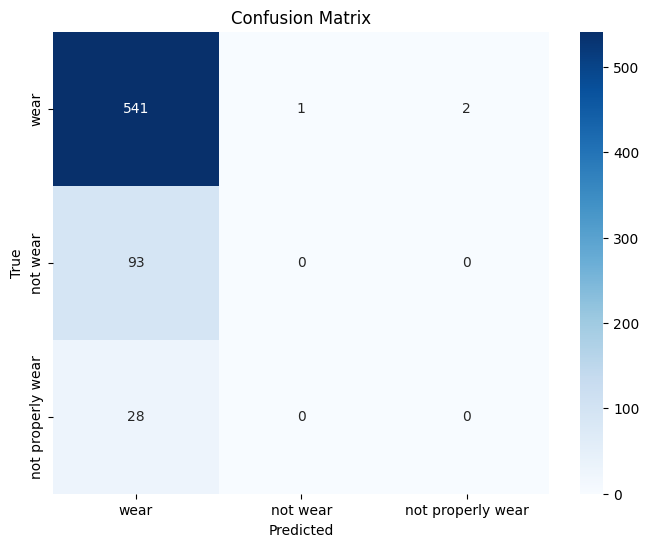

In [18]:
############################
# Coded by Goh Jin Yu
############################
import os
from ultralytics import YOLO
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load model
model = YOLO('/kaggle/working/yolov8n.pt')

# Set paths
image_dir = '/kaggle/working/dataset/images/train'
label_dir = '/kaggle/working/dataset/labels/train'

# Classes
class_names = ["wear", "not wear", "not properly wear"]

# Helper to load ground truth labels
def load_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])  # class ID
        labels.append(class_id)
    return labels

# Collect all predictions and ground truths
y_true = []
y_pred = []

image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + '.txt')

    # Load ground truth
    true_classes = load_labels(label_path)

    # Predict
    results = model(img_path, conf=0.25, iou=0.5)  # you can adjust conf threshold
    pred_classes = results[0].boxes.cls.cpu().numpy().astype(int) if results[0].boxes is not None else []

    # Match predictions to ground truths
    # Simple version: assume 1 object per image, match first prediction
    if len(true_classes) > 0:
        gt_class = true_classes[0]  # take first ground truth class
        pred_class = pred_classes[0] if len(pred_classes) > 0 else -1  # if no prediction, use -1
        y_true.append(gt_class)
        y_pred.append(pred_class)

# Keep only entries where both ground truth and prediction are in [0, 1, 2]
valid_classes = [0, 1, 2]

filtered_indices = [i for i in range(len(y_true)) if (y_true[i] in valid_classes) and (y_pred[i] in valid_classes)]

y_true_filtered = np.array(y_true)[filtered_indices]
y_pred_filtered = np.array(y_pred)[filtered_indices]

# Now generate the classification report
print(classification_report(y_true_filtered, y_pred_filtered, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

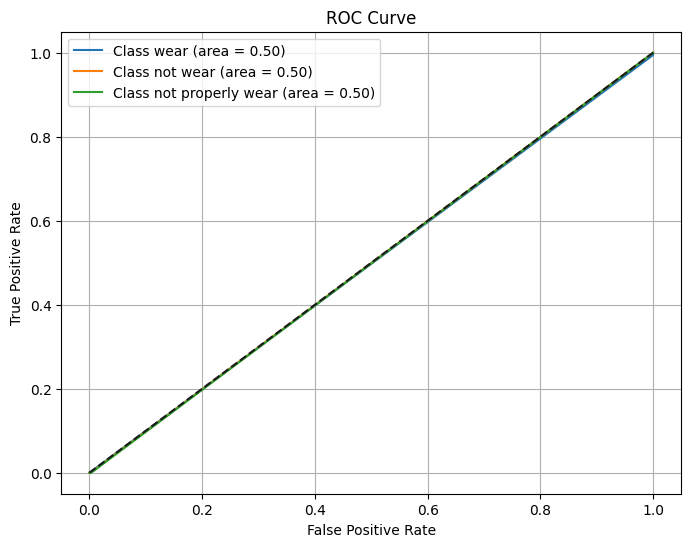

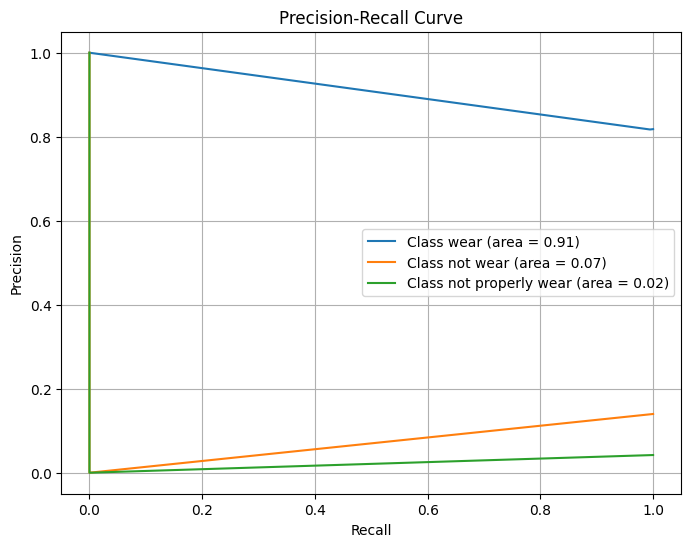

In [19]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# One-hot encode y_true for ROC and PR curve
from sklearn.preprocessing import label_binarize

# Binarize
y_true_bin = label_binarize(y_true_filtered, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred_filtered, classes=[0, 1, 2])

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8,6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot PR Curve
plt.figure(figsize=(8,6))
for i in range(3):
    plt.plot(recall[i], precision[i], label=f'Class {class_names[i]} (area = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()



image 1/1 /kaggle/working/dataset/images/train/maksssksksss792.png: 384x640 9 persons, 1 cell phone, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


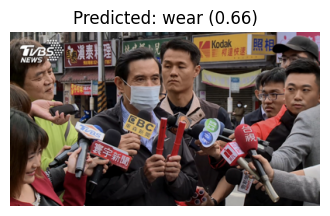


image 1/1 /kaggle/working/dataset/images/train/maksssksksss353.png: 448x640 2 persons, 2 motorcycles, 1 tie, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


IndexError: list index out of range

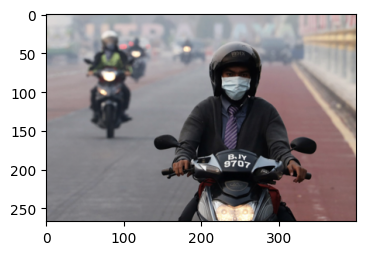

In [21]:
from PIL import Image

# Example visualization
for idx in range(10):  # Show 10 samples
    img_file = image_files[idx]
    img_path = os.path.join(image_dir, img_file)

    img = Image.open(img_path)
    results = model(img_path)

    # Draw predicted label
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    pred_classes = results[0].boxes.cls.cpu().numpy().astype(int)
    confs = results[0].boxes.conf.cpu().numpy()
    if len(pred_classes) > 0:
        pred_label = class_names[pred_classes[0]]
        confidence = confs[0]
        plt.title(f"Predicted: {pred_label} ({confidence:.2f})")
    else:
        plt.title(f"No prediction")
    plt.axis('off')
    plt.show()

In [22]:
from collections import Counter

# Count ground truth classes
all_labels = []
for label_file in os.listdir(label_dir):
    path = os.path.join(label_dir, label_file)
    labels = load_labels(path)
    all_labels.extend(labels)

counter = Counter(all_labels)
for class_id, count in counter.items():
    print(f"Class {class_id} ({class_names[class_id]}): {count} samples")


Class 0 (wear): 2435 samples
Class 1 (not wear): 583 samples
Class 2 (not properly wear): 96 samples
